In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignment1_colab/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignment1_colab/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignment1_colab/assignment1


# k-Nearest Neighbor (kNN) exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

The kNN classifier consists of two stages:

- During training, the classifier takes the training data and simply remembers it
- During testing, kNN classifies every test image by comparing to all training images and transfering the labels of the k most similar training examples
- The value of k is cross-validated

In this exercise you will implement these steps and understand the basic Image Classification pipeline, cross-validation, and gain proficiency in writing efficient, vectorized code.

In [2]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# # Some more magic so that the notebook will reload external python modules;
# # see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
# %load_ext autoreload
# %autoreload 2

In [3]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


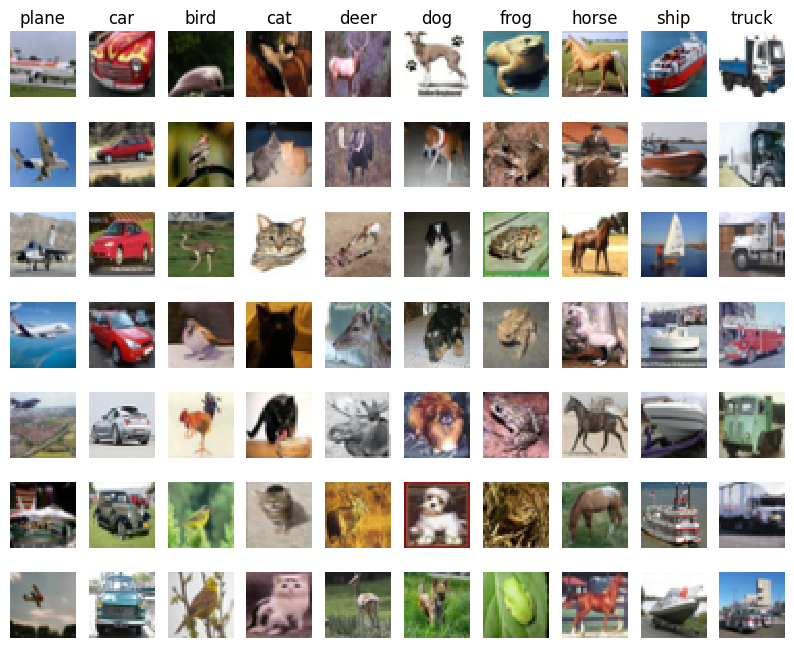

In [4]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [5]:
# Subsample the data for more efficient code execution in this exercise
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

(5000, 3072) (500, 3072)


In [6]:
from cs231n.classifiers import KNearestNeighbor

# Create a kNN classifier instance.
# Remember that training a kNN classifier is a noop:
# the Classifier simply remembers the data and does no further processing
classifier = KNearestNeighbor()
classifier.train(X_train, y_train)

We would now like to classify the test data with the kNN classifier. Recall that we can break down this process into two steps:

1. First we must compute the distances between all test examples and all train examples.
2. Given these distances, for each test example we find the k nearest examples and have them vote for the label

Lets begin with computing the distance matrix between all training and test examples. For example, if there are **Ntr** training examples and **Nte** test examples, this stage should result in a **Nte x Ntr** matrix where each element (i,j) is the distance between the i-th test and j-th train example.

**Note: For the three distance computations that we require you to implement in this notebook, you may not use the np.linalg.norm() function that numpy provides.**

First, open `cs231n/classifiers/k_nearest_neighbor.py` and implement the function `compute_distances_two_loops` that uses a (very inefficient) double loop over all pairs of (test, train) examples and computes the distance matrix one element at a time.

In [7]:
# Open cs231n/classifiers/k_nearest_neighbor.py and implement
# compute_distances_two_loops.

# Test your implementation:
dists = classifier.compute_distances_two_loops(X_test)
print(dists.shape)

(500, 5000)


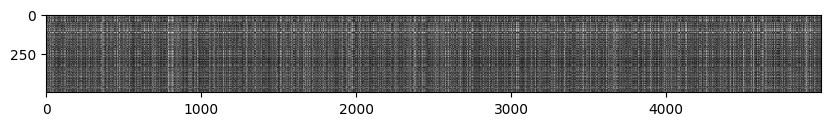

In [8]:
# We can visualize the distance matrix: each row is a single test example and
# its distances to training examples
plt.imshow(dists, interpolation='none')
plt.show()

### For Inline Question 1

Top median rows: [385 218  21  98 382]


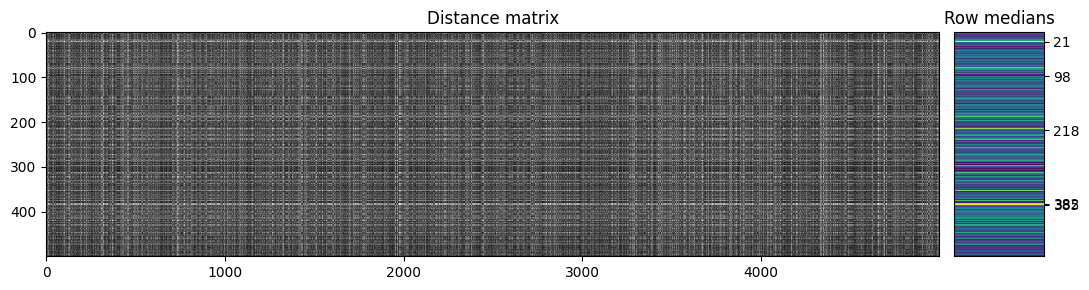

In [9]:
row_medians = np.median(dists, axis=1)
num_top_median_rows = 5
top_median_rows = np.argsort(row_medians)
top_median_rows = top_median_rows[::-1][:num_top_median_rows]
print(f"Top median rows: {top_median_rows}")

fig, axes = plt.subplots(
    1, 2, figsize=(11, 3),
    gridspec_kw={'width_ratios':[10,1]}
)

# Heatmap of distances
axes[0].imshow(dists, interpolation='none', aspect='auto')
axes[0].set_title("Distance matrix")

# Row medians
median_img = axes[1].imshow(
    row_medians[:, None], interpolation='none', aspect='auto', cmap='viridis',
)
axes[1].set_title("Row medians")
axes[1].set_xticks([])
axes[1].yaxis.tick_right()
axes[1].set_yticks(top_median_rows)

fig.tight_layout()

# The ticks appear to be a little off in this median plot, but increasing
# the height (try about 50) shows that they are at the large median rows

In [10]:
def plot_image(ax, img_flattened):
    "helper function"
    img = img_flattened.reshape(32, 32, 3)
    ax.imshow(img.astype('uint8'))
    ax.axis('off')

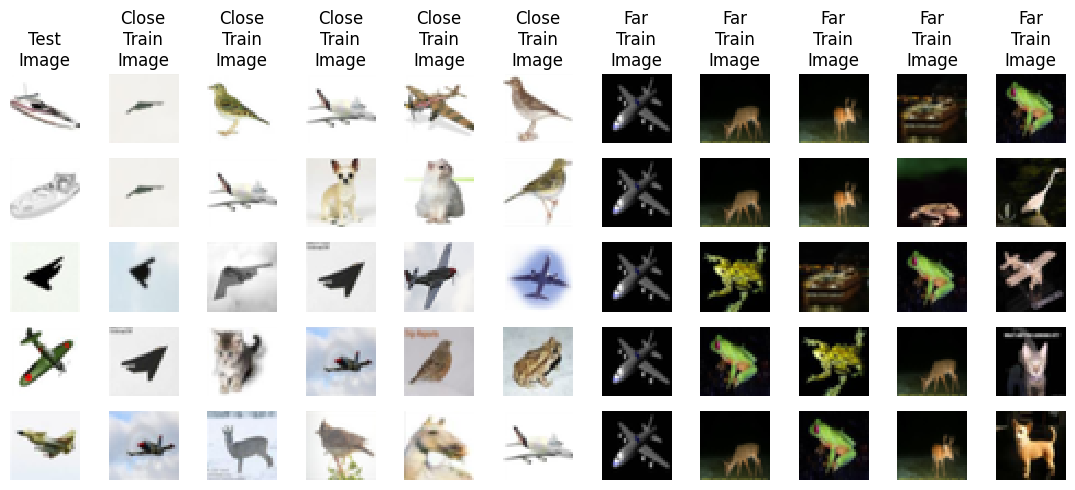

In [11]:
# Visualize bright row images
# For each row, take the 5 cols with smallest dist
# and take 5 cols with the largest dist
# and then plot the 11 images for each row

num_images_one_side = 5
nr = num_top_median_rows
nc = 2 * num_images_one_side + 1
fig, ax = plt.subplots(
    nr, nc, figsize=(nc * 1, nr * 1)
)

for plt_row, row_idx in enumerate(top_median_rows):
    dists_i = dists[row_idx, :]
    idxs_sorted = np.argsort(dists_i)

    closest_image_idxs = idxs_sorted[:num_images_one_side]
    farthest_image_idxs = idxs_sorted[::-1][:num_images_one_side]

    # Plot the test img
    plot_image(ax[plt_row][0], X_test[row_idx, :])
    if plt_row == 0:
        ax[plt_row][0].set_title("Test\nImage")

    # Plot the closest imgs
    for i, cls_img_idx in enumerate(closest_image_idxs):
        plot_image(ax[plt_row][1 + i], X_train[cls_img_idx, :])
        if plt_row == 0:
            ax[plt_row][1 + i].set_title("Close\nTrain\nImage")

    # Plot the farthest imgs
    for i, frt_img_idx in enumerate(farthest_image_idxs):
        plot_image(
            ax[plt_row][1 + num_images_one_side + i],
            X_train[frt_img_idx, :]
        )
        if plt_row == 0:
            ax[plt_row][1 + num_images_one_side + i].set_title(
                "Far\nTrain\nImage"
            )

    fig.tight_layout()

Least median rows: [183 326 295 291 309]


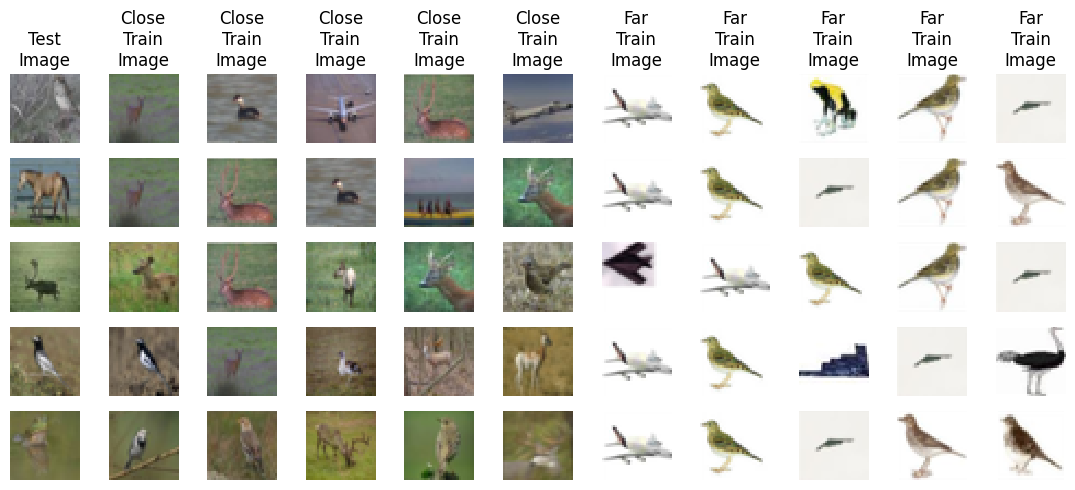

In [12]:
# Let's also visualize dark row images
# For each row, take the 5 cols with smallest dist
# and take 5 cols with the largest dist
# and then plot the 11 images for each row

row_medians = np.median(dists, axis=1)
num_least_median_rows = 5
least_median_rows = np.argsort(row_medians)
least_median_rows = least_median_rows[:num_top_median_rows]
print(f"Least median rows: {least_median_rows}")

num_images_one_side = 5
nr = num_least_median_rows
nc = 2 * num_images_one_side + 1
fig, ax = plt.subplots(
    nr, nc, figsize=(nc * 1, nr * 1)
)

for plt_row, row_idx in enumerate(least_median_rows):
    dists_i = dists[row_idx, :]
    idxs_sorted = np.argsort(dists_i)

    closest_image_idxs = idxs_sorted[:num_images_one_side]
    farthest_image_idxs = idxs_sorted[::-1][:num_images_one_side]

    # Plot the test img
    plot_image(ax[plt_row][0], X_test[row_idx, :])
    if plt_row == 0:
        ax[plt_row][0].set_title("Test\nImage")

    # Plot the closest imgs
    for i, cls_img_idx in enumerate(closest_image_idxs):
        plot_image(ax[plt_row][1 + i], X_train[cls_img_idx, :])
        if plt_row == 0:
            ax[plt_row][1 + i].set_title("Close\nTrain\nImage")

    # Plot the farthest imgs
    for i, frt_img_idx in enumerate(farthest_image_idxs):
        plot_image(
            ax[plt_row][1 + num_images_one_side + i],
            X_train[frt_img_idx, :]
        )
        if plt_row == 0:
            ax[plt_row][1 + num_images_one_side + i].set_title(
                "Far\nTrain\nImage"
            )

    fig.tight_layout()

**Let's look at the columns now**

Top median cols: [4601 2744  504  790 1527]


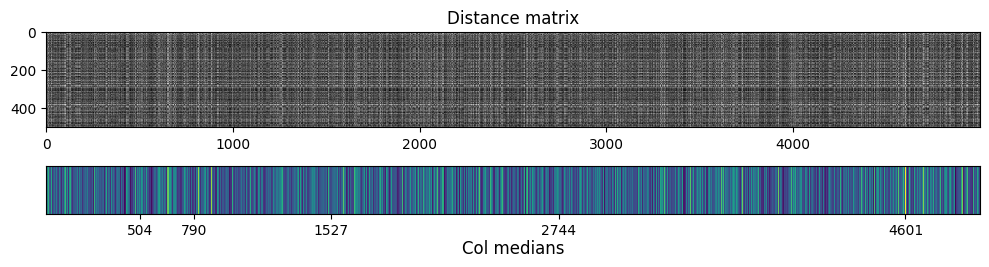

In [13]:
col_medians = np.median(dists, axis=0)
num_top_median_cols = 5
top_median_cols = np.argsort(col_medians)
top_median_cols = top_median_cols[::-1][:num_top_median_cols]
print(f"Top median cols: {top_median_cols}")

fig, axes = plt.subplots(
    2, 1, figsize=(10, 3),
    gridspec_kw={'height_ratios':[2,1]}
)

# Heatmap of distances
axes[0].imshow(dists, interpolation='none', aspect='auto')
axes[0].set_title("Distance matrix")

# Row medians
median_img = axes[1].imshow(
    col_medians[None, :], interpolation='none', aspect='auto', cmap='viridis',
)
axes[1].set_title("Col medians", y=-1)
axes[1].set_xticks(top_median_cols)
axes[1].set_yticks([])

fig.tight_layout()

# The ticks appear to be a little off in this median plot, but increasing
# the width (try about 120) shows that they are at the large median cols

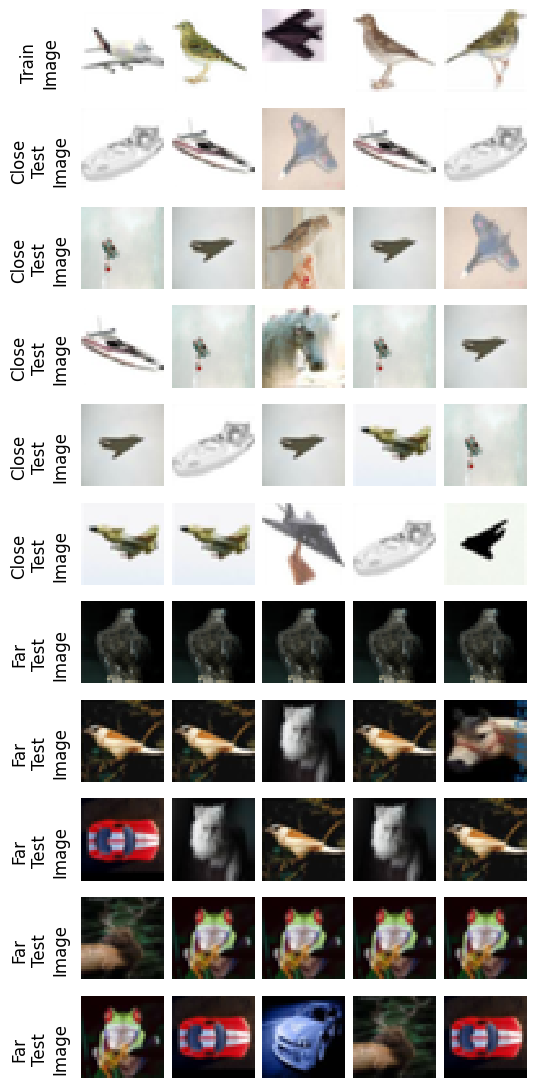

In [14]:
# Visualize bright col images
# For each col, take the 5 rows with smallest dist
# and take 5 rows with the largest dist
# and then plot the 11 images for each col

num_images_one_side = 5
nc = num_top_median_cols
nr = 2 * num_images_one_side + 1
fig, ax = plt.subplots(
    nr, nc, figsize=(nc * 1, nr * 1)
)

for plt_col, row_idx in enumerate(top_median_cols):
    dists_j = dists[:, row_idx]
    idxs_sorted = np.argsort(dists_j)

    closest_image_idxs = idxs_sorted[:num_images_one_side]
    farthest_image_idxs = idxs_sorted[::-1][:num_images_one_side]

    # Plot the train img
    plot_image(ax[0][plt_col], X_train[row_idx, :])
    if plt_col == 0:
        ax[0][plt_col].set_title(
            "Train\nImage", rotation=90,
            x=-0.5, y=-0.01,
        )

    # Plot the closest imgs
    for i, cls_img_idx in enumerate(closest_image_idxs):
        plot_image(ax[1 + i][plt_col], X_test[cls_img_idx, :])
        if plt_col == 0:
            ax[1 + i][plt_col].set_title(
                "Close\nTest\nImage", rotation=90,
                x=-0.5, y=-0.01,
            )

    # Plot the farthest imgs
    for i, frt_img_idx in enumerate(farthest_image_idxs):
        plot_image(
            ax[1 + num_images_one_side + i][plt_col],
            X_test[frt_img_idx, :]
        )
        if plt_col == 0:
            ax[1 + num_images_one_side + i][plt_col].set_title(
                "Far\nTest\nImage", rotation=90,
                x=-0.5, y=-0.01,
            )

    fig.tight_layout()

Least median cols: [4224 4868 1500  420 1284]


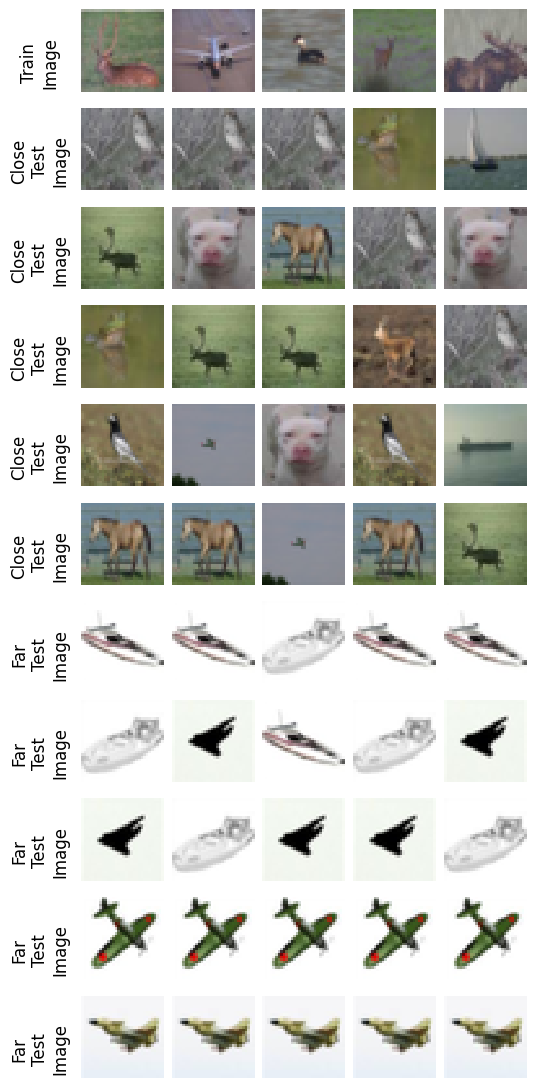

In [15]:
# Visualize dark col images
# For each col, take the 5 rows with smallest dist
# and take 5 rows with the largest dist
# and then plot the 11 images for each col

col_medians = np.median(dists, axis=0)
num_least_median_cols = 5
least_median_cols = np.argsort(col_medians)
least_median_cols = least_median_cols[:num_least_median_cols]
print(f"Least median cols: {least_median_cols}")

num_images_one_side = 5
nc = num_least_median_cols
nr = 2 * num_images_one_side + 1
fig, ax = plt.subplots(
    nr, nc, figsize=(nc * 1, nr * 1)
)

for plt_col, row_idx in enumerate(least_median_cols):
    dists_j = dists[:, row_idx]
    idxs_sorted = np.argsort(dists_j)

    closest_image_idxs = idxs_sorted[:num_images_one_side]
    farthest_image_idxs = idxs_sorted[::-1][:num_images_one_side]

    # Plot the train img
    plot_image(ax[0][plt_col], X_train[row_idx, :])
    if plt_col == 0:
        ax[0][plt_col].set_title(
            "Train\nImage", rotation=90,
            x=-0.5, y=-0.01,
        )

    # Plot the closest imgs
    for i, cls_img_idx in enumerate(closest_image_idxs):
        plot_image(ax[1 + i][plt_col], X_test[cls_img_idx, :])
        if plt_col == 0:
            ax[1 + i][plt_col].set_title(
                "Close\nTest\nImage", rotation=90,
                x=-0.5, y=-0.01,
            )

    # Plot the farthest imgs
    for i, frt_img_idx in enumerate(farthest_image_idxs):
        plot_image(
            ax[1 + num_images_one_side + i][plt_col],
            X_test[frt_img_idx, :]
        )
        if plt_col == 0:
            ax[1 + num_images_one_side + i][plt_col].set_title(
                "Far\nTest\nImage", rotation=90,
                x=-0.5, y=-0.01,
            )

    fig.tight_layout()

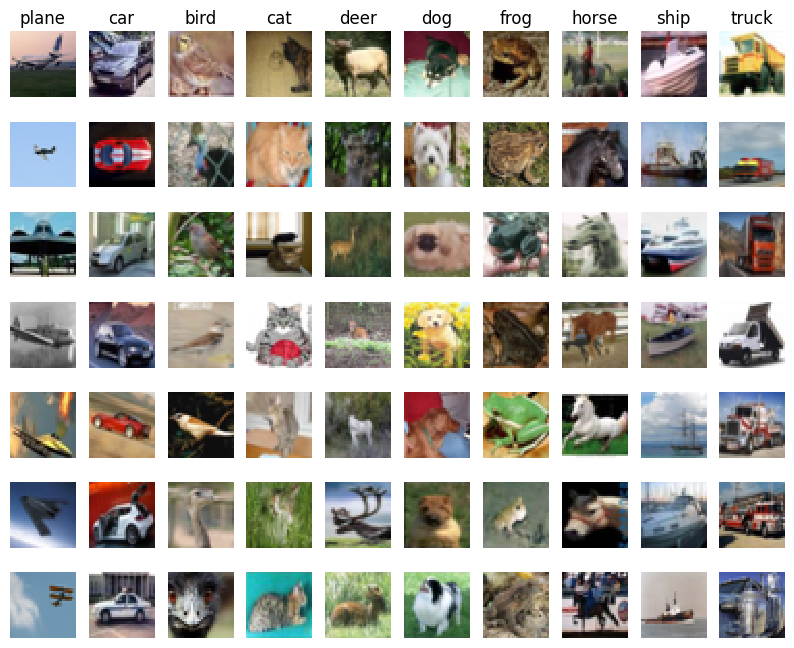

In [16]:
# Visualize some examples from the test dataset.
# We show a few examples of test images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_test == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_test[idx].reshape(32, 32, 3).astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

**Inline Question 1**

Notice the structured patterns in the distance matrix, where some rows or columns are visibly brighter. (Note that with the default color scheme black indicates low distances while white indicates high distances.)

- What in the data is the cause behind the distinctly bright rows?
- What causes the columns?

$\color{blue}{\textit Your Answer:}$
- Distinctly bright rows are apparently caused by images which have mostly white background (sky or artificially removed). From the random images displayed at the top of this notebook, we see that most images do not have mostly white background, so an image with this kind of background would have a large distance to most train images, leading to bright row.
- Same reason for the columns

In [17]:
# Now implement the function predict_labels and run the code below:
# We use k = 1 (which is Nearest Neighbor).
y_test_pred = classifier.predict_labels(dists, k=1)

# Compute and print the fraction of correctly predicted examples
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 137 / 500 correct => accuracy: 0.274000


You should expect to see approximately `27%` accuracy. Now lets try out a larger `k`, say `k = 5`:

In [18]:
y_test_pred = classifier.predict_labels(dists, k=5)
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 139 / 500 correct => accuracy: 0.278000


You should expect to see a slightly better performance than with `k = 1`.

**Inline Question 2**

We can also use other distance metrics such as L1 distance.
For pixel values $p_{ij}^{(k)}$ at location $(i,j)$ of some image $I_k$,

the mean $\mu$ across all pixels over all images is $$\mu=\frac{1}{nhw}\sum_{k=1}^n\sum_{i=1}^{h}\sum_{j=1}^{w}p_{ij}^{(k)}$$
And the pixel-wise mean $\mu_{ij}$ across all images is
$$\mu_{ij}=\frac{1}{n}\sum_{k=1}^np_{ij}^{(k)}.$$
The general standard deviation $\sigma$ and pixel-wise standard deviation $\sigma_{ij}$ is defined similarly.

Which of the following preprocessing steps will not change the performance of a Nearest Neighbor classifier that uses L1 distance? Select all that apply. To clarify, both training and test examples are preprocessed in the same way.

1. Subtracting the mean $\mu$ ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu$.)
2. Subtracting the per pixel mean $\mu_{ij}$  ($\tilde{p}_{ij}^{(k)}=p_{ij}^{(k)}-\mu_{ij}$.)
3. Subtracting the mean $\mu$ and dividing by the standard deviation $\sigma$.
4. Subtracting the pixel-wise mean $\mu_{ij}$ and dividing by the pixel-wise standard deviation $\sigma_{ij}$.
5. Rotating the coordinate axes of the data, which means rotating all the images by the same angle. Empty regions in the image caused by rotation are padded with a same pixel value and no interpolation is performed.

$\color{blue}{\textit Your Answer:}$
Assuming the same mean, std dev values are used for both train and test sets
1. &#x2717; Will NOT change the performance
2. &#x2717; Will NOT change the performance
3. &#x2717; Will NOT change the performance
4. &#x2713; May change the performance
5. &#x2713; May change the performance

$\color{blue}{\textit Your Explanation:}$
1. $\tilde{p}_{ij}^{(k)} - \tilde{p}_{ij}^{(l)} = (p_{ij}^{(k)} - \mu) - (p_{ij}^{(l)} - \mu) = p_{ij}^{(k)} - p_{ij}^{(l)}$
2. $\tilde{p}_{ij}^{(k)} - \tilde{p}_{ij}^{(l)} = (p_{ij}^{(k)} - \mu_{ij}) - (p_{ij}^{(l)} - \mu_{ij}) = p_{ij}^{(k)} - p_{ij}^{(l)}$
3. $\tilde{p}_{ij}^{(k)} - \tilde{p}_{ij}^{(l)} = \frac{(p_{ij}^{(k)} - \mu)}{\sigma} - \frac{(p_{ij}^{(l)} - \mu)}{\sigma} = \frac{p_{ij}^{(k)} - p_{ij}^{(l)}}{\sigma}$. This is just scaling, order remains the same.
4. $\tilde{p}_{ij}^{(k)} - \tilde{p}_{ij}^{(l)} = \frac{(p_{ij}^{(k)} - \mu_{ij})}{\sigma_{ij}} - \frac{(p_{ij}^{(l)} - \mu_{ij})}{\sigma_{ij}} = \frac{p_{ij}^{(k)} - p_{ij}^{(l)}}{\sigma_{ij}}$. This is weighted sum, same performance not guaranteed here (example in code cell below)
5. This may change the performance. Assume pixel indices $S$ are removed from each image. Now assume three images $I_{A}$, $I_{B}$, $I_{C}$ such that $I_{A}$ and $I_{B}$ are same at pixels $S$, but different at pixels $S^{c}$ (with distance 0.1), and $I_{A}$ and $I_{C}$ are same at pixels $S^{c}$, but different at pixels $S$ (with distance 0.2). After removal of set S, dist($I_{A}$, $I_{B}$) = 0.1, and dist($I_{A}$, $I_{C}$) = 0. Distance order has changed.

In [19]:
import numpy as np

def iq2_example_get_dists(v1, v2, s1, s2, s3):
    d1 = (
        np.abs(v1[0] - v2[0])
        + np.abs(v1[1] - v2[1])
        + np.abs(v1[2] - v2[2])
    )
    d2 = (
        (np.abs(v1[0] - v2[0]) / s1)
        + (np.abs(v1[1] - v2[1]) / s2)
        + (np.abs(v1[2] - v2[2]) / s3)
    )
    return d1, d2

vec_1 = [1, 2, 3]
vec_2 = [0.1, 0.2, 3.5]
vec_3 = [2, 3, 4]

s1 = np.std([
    vec_1[0], vec_2[0], vec_3[0],
])
s2 = np.std([
    vec_1[1], vec_2[1], vec_3[1],
])
s3 = np.std([
    vec_1[2], vec_2[2], vec_3[2],
])

print(iq2_example_get_dists(vec_1, vec_2, s1, s2, s3))
print(iq2_example_get_dists(vec_1, vec_3, s1, s2, s3))

# By L1 distance, vec_1 and vec_3 are closer
# By L1 distance on scaled components, vec_1 and vec_2 are closer

(np.float64(3.2), np.float64(3.938169587928772))
(np.int64(3), np.float64(4.601253088018505))


In [20]:
# Now lets speed up distance matrix computation by using partial vectorization
# with one loop. Implement the function compute_distances_one_loop and run the
# code below:
dists_one = classifier.compute_distances_one_loop(X_test)

# To ensure that our vectorized implementation is correct, we make sure that it
# agrees with the naive implementation. There are many ways to decide whether
# two matrices are similar; one of the simplest is the Frobenius norm. In case
# you haven't seen it before, the Frobenius norm of two matrices is the square
# root of the squared sum of differences of all elements; in other words, reshape
# the matrices into vectors and compute the Euclidean distance between them.
difference = np.linalg.norm(dists - dists_one, ord='fro')
print('One loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

One loop difference was: 0.000000
Good! The distance matrices are the same


In [21]:
# Now implement the fully vectorized version inside compute_distances_no_loops
# and run the code
dists_two = classifier.compute_distances_no_loops(X_test)

# check that the distance matrix agrees with the one we computed before:
difference = np.linalg.norm(dists - dists_two, ord='fro')
print('No loop difference was: %f' % (difference, ))
if difference < 0.001:
    print('Good! The distance matrices are the same')
else:
    print('Uh-oh! The distance matrices are different')

No loop difference was: 0.000000
Good! The distance matrices are the same


In [22]:
# Let's compare how fast the implementations are
def time_function(f, *args):
    """
    Call a function f with args and return the time (in seconds) that it took to execute.
    """
    import time
    tic = time.time()
    f(*args)
    toc = time.time()
    return toc - tic

two_loop_time = time_function(classifier.compute_distances_two_loops, X_test)
print('Two loop version took %f seconds' % two_loop_time)

one_loop_time = time_function(classifier.compute_distances_one_loop, X_test)
print('One loop version took %f seconds' % one_loop_time)

no_loop_time = time_function(classifier.compute_distances_no_loops, X_test)
print('No loop version took %f seconds' % no_loop_time)

# You should see significantly faster performance with the fully vectorized implementation!

# NOTE: depending on what machine you're using,
# you might not see a speedup when you go from two loops to one loop,
# and might even see a slow-down.

Two loop version took 42.752441 seconds
One loop version took 36.865407 seconds
No loop version took 0.646979 seconds


### Cross-validation

We have implemented the k-Nearest Neighbor classifier but we set the value k = 5 arbitrarily. We will now determine the best value of this hyperparameter with cross-validation.

In [23]:
num_folds = 5
k_choices = [1, 3, 5, 8, 10, 12, 15, 20, 50, 100]

X_train_folds = []
y_train_folds = []
################################################################################
# TODO:                                                                        #
# Split up the training data into folds. After splitting, X_train_folds and    #
# y_train_folds should each be lists of length num_folds, where                #
# y_train_folds[i] is the label vector for the points in X_train_folds[i].     #
# Hint: Look up the numpy array_split function.                                #
################################################################################

num_train = X_train.shape[0]
idxs = list(range(num_train))

rng = np.random.default_rng(seed=0)
rng.shuffle(idxs)

fold_idxs_list = np.array_split(idxs, num_folds)
for fold_idxs in fold_idxs_list:
    X_train_folds.append(X_train[fold_idxs, :])
    y_train_folds.append(y_train[fold_idxs])

# A dictionary holding the accuracies for different values of k that we find
# when running cross-validation. After running cross-validation,
# k_to_accuracies[k] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of k.
k_to_accuracies = {}


################################################################################
# TODO:                                                                        #
# Perform k-fold cross validation to find the best value of k. For each        #
# possible value of k, run the k-nearest-neighbor algorithm num_folds times,   #
# where in each case you use all but one of the folds as training data and the #
# last fold as a validation set. Store the accuracies for all fold and all     #
# values of k in the k_to_accuracies dictionary.                               #
################################################################################

for k in k_choices:
    k_to_accuracies[k] = []

    for test_fold_idx in range(num_folds):
        test_fold_X = X_train_folds[test_fold_idx]
        test_fold_y = y_train_folds[test_fold_idx]

        train_fold_X = np.vstack([
            X_train_folds[fold_idx] for fold_idx in range(num_folds)
            if fold_idx != test_fold_idx
        ])
        train_fold_y = np.hstack([
            y_train_folds[fold_idx] for fold_idx in range(num_folds)
            if fold_idx != test_fold_idx
        ])

        classifier = KNearestNeighbor()
        classifier.train(train_fold_X, train_fold_y)
        dists = classifier.compute_distances_no_loops(test_fold_X)
        test_fold_pred = classifier.predict_labels(dists, k=k)

        accuracy = np.mean(test_fold_y == test_fold_pred)
        k_to_accuracies[k].append(accuracy)

# Print out the computed accuracies
for k in sorted(k_to_accuracies):
    for accuracy in k_to_accuracies[k]:
        print('k = %d, accuracy = %f' % (k, accuracy))

k = 1, accuracy = 0.261000
k = 1, accuracy = 0.266000
k = 1, accuracy = 0.268000
k = 1, accuracy = 0.280000
k = 1, accuracy = 0.275000
k = 3, accuracy = 0.261000
k = 3, accuracy = 0.241000
k = 3, accuracy = 0.263000
k = 3, accuracy = 0.264000
k = 3, accuracy = 0.242000
k = 5, accuracy = 0.259000
k = 5, accuracy = 0.249000
k = 5, accuracy = 0.265000
k = 5, accuracy = 0.274000
k = 5, accuracy = 0.267000
k = 8, accuracy = 0.273000
k = 8, accuracy = 0.282000
k = 8, accuracy = 0.262000
k = 8, accuracy = 0.281000
k = 8, accuracy = 0.268000
k = 10, accuracy = 0.260000
k = 10, accuracy = 0.289000
k = 10, accuracy = 0.268000
k = 10, accuracy = 0.271000
k = 10, accuracy = 0.280000
k = 12, accuracy = 0.260000
k = 12, accuracy = 0.289000
k = 12, accuracy = 0.272000
k = 12, accuracy = 0.282000
k = 12, accuracy = 0.284000
k = 15, accuracy = 0.268000
k = 15, accuracy = 0.274000
k = 15, accuracy = 0.277000
k = 15, accuracy = 0.270000
k = 15, accuracy = 0.279000
k = 20, accuracy = 0.270000
k = 20, accu

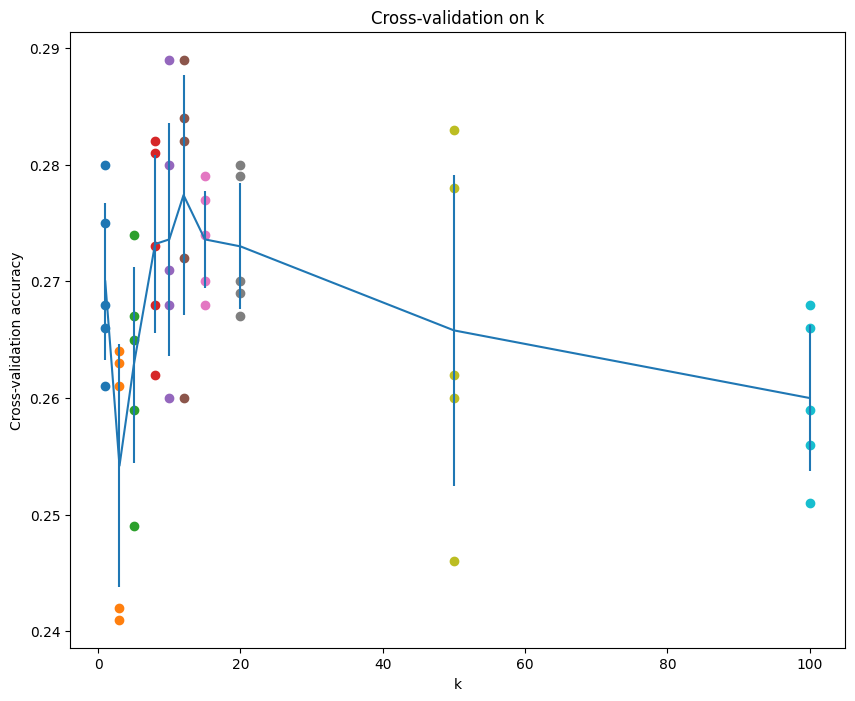

In [24]:
# plot the raw observations
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [25]:
k_to_mean_accuracy = {
    k: np.mean(v) for k, v in k_to_accuracies.items()
}
k_to_mean_accuracy

{1: np.float64(0.27),
 3: np.float64(0.2542),
 5: np.float64(0.26280000000000003),
 8: np.float64(0.2732),
 10: np.float64(0.2736),
 12: np.float64(0.2774),
 15: np.float64(0.27359999999999995),
 20: np.float64(0.273),
 50: np.float64(0.2658),
 100: np.float64(0.26)}

In [26]:
# Based on the cross-validation results above, choose the best value for k,
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 28% accuracy on the test data.
best_k = 10

classifier = KNearestNeighbor()
classifier.train(X_train, y_train)
y_test_pred = classifier.predict(X_test, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 141 / 500 correct => accuracy: 0.282000


**Inline Question 3**

Which of the following statements about $k$-Nearest Neighbor ($k$-NN) are true in a classification setting, and for all $k$? Select all that apply.
1. The decision boundary of the k-NN classifier is linear.
2. The training error of a 1-NN will always be lower than or equal to that of 5-NN.
3. The test error of a 1-NN will always be lower than that of a 5-NN.
4. The time needed to classify a test example with the k-NN classifier grows with the size of the training set.
5. None of the above.

$\color{blue}{\textit Your Answer:}$
Statements which are true: 2, 4

$\color{blue}{\textit Your Explanation:}$
1. This is false. For k = 1, the boundary is piecewise linear. This need not be true, and usually would not be true.
2. Training error of 1-NN = 0 because closest train example is the same as input.
3. The test error may follow any order. 5-NN may be better in case there is an overfitting problem with 1-NN
4. The number of distances to be calculated grows, so time needed grows